In [1]:
%load_ext watermark

In [2]:
%watermark

Last updated: 2022-07-21T13:04:55.036790+03:00

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.22.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [3]:
import os
import pickle as pkl
#import tqdm

import numpy as np
import pandas as pd

from sklearn.metrics import r2_score
from sklearn import preprocessing
import lightgbm as lgb

from itertools import product
from typing import Tuple

In [4]:
from tqdm.auto import tqdm
tqdm.pandas()

In [5]:
#from catboost import __version__ as cb_version
from sklearn import __version__ as sklearn_version

#print(f'cb_version: {cb_version}')
print(f'sklearn_version: {sklearn_version}')

sklearn_version: 0.24.2


In [6]:
%watermark --iversions

sklearn : 0.24.2
pandas  : 0.25.3
numpy   : 1.20.3
lightgbm: 3.3.2



## Reproducibility block

In [7]:
# seed the RNG for all devices (both CPU and CUDA)
#torch.manual_seed(1984)

#Disabling the benchmarking feature causes cuDNN to deterministically select an algorithm, 
#possibly at the cost of reduced performance.
#torch.backends.cudnn.benchmark = False

# for custom operators,
import random
random.seed(5986721)

# 
np.random.seed(62185)

#sklearn take seed from a line abowe

CB_RANDOMSEED  = 309487
XGB_RANDOMSEED = 56
LGB_RANDOMSEED = 874256

In [8]:
DIR_DATA   = os.path.join(os.getcwd(), 'data')
DIR_MODELS = os.path.join(os.getcwd(), 'models')
DIR_SUBM   = os.path.join(os.getcwd(), 'subm')
DIR_SUBM_PART = os.path.join(os.getcwd(), 'subm', 'partial')

In [9]:
NTRY = 25
NAME = f'{NTRY}_lgb_pca64_sber_bord_nose_iter_2mod'

In [10]:
VIEWS_UKR = 2554204
DEPTH_UKR = 1.799
FPR_UKR = 4.978

## Load data

In [11]:
df_train = pd.read_csv(os.path.join(DIR_DATA, 'train_upd.csv'))#, index_col= 0)
df_test  = pd.read_csv(os.path.join(DIR_DATA, 'test_upd.csv'))#, index_col= 0)

with open(os.path.join(DIR_DATA, 'clmns.pkl'), 'rb') as pickle_file:
    clmns = pkl.load(pickle_file)

In [12]:
df_train.shape, df_test.shape,

((6981, 293), (3000, 290))

In [13]:
df_train['category'] = df_train['category'].astype('category')
df_test['category']  = df_test['category'].astype('category')

In [14]:
cat_cols = []
num_cols = []

for el in clmns.keys():
    cat_cols.extend(clmns[el]['cat'])
    num_cols.extend(clmns[el]['num'])
    if len(clmns[el]['both']) != 0:
        print(clmns[el]['both'])

['ph_report', 'ph_gallery', 'tv_prog', 'online', 'video', 'infogr']
['hour', 'dow', 'day', 'mounth', 'holiday', 'day_before_holiday', 'day_after_holiday', 'distrib_brdr']


In [15]:
num_cols.extend(['hour', 'mounth'])
cat_cols.extend([ 'dow',
                'ph_report', 'ph_gallery', 'tv_prog', 'online', 'video', 'infogr',
                 'holiday', 'day_before_holiday', 'day_after_holiday', #'distrib_brdr',
                 #'spec_event_1',
                ])

In [16]:
def r2(preds: np.ndarray, data: lgb.Dataset) -> Tuple[str, float, bool]:
    label = data.get_label()
    #weight = data.get_weight()
    #p_dash = (1 - label) + (2 * label - 1) * preds
    #loss_by_example = - np.log(p_dash)
    #loss = np.average(loss_by_example, weights=weight)

    # # eval_name, eval_result, is_higher_better
    return 'r2', r2_score(preds, label), True

In [17]:
def train_lgb_cat(inp_df, inp_vals, inp_category, inp_cat_cols, inp_num_cols):

    
    num_of_leaves_vars    = [4, 8, 16, 32, 64, 128]
    max_depth_vars        = [4, 8, 16, 32]#, 64, 128]
    min_data_in_leaf_vars = [4, 8, 16, 32]#, 64, 128]
    learn_rate_vars       = [0.1, 0.05, 0.01] #1, 0.5, 
    
    min_rmse = 1000000
    ret_progress = []
    
    for nl, lr, md, mdlf in tqdm(product(num_of_leaves_vars, learn_rate_vars, max_depth_vars, min_data_in_leaf_vars), 
                                total = len(num_of_leaves_vars)*len(learn_rate_vars)*len(max_depth_vars)*len(min_data_in_leaf_vars)
                                ):
    
        params = {
            'task': 'train', 
            'boosting': 'gbdt',
            'objective': 'regression',
            'num_leaves': nl,
            'learning_rate': lr,
            'max_depth': md,
            'min_data_in_leaf': mdlf,
            'metric': {'rmse'},
            #'verbose': -1,
            'random_seed': LGB_RANDOMSEED,
            'force_col_wise': False,
            'n_jobs' : -1,
            
            
            #'reg_alpha': 10,   # != 0  Hard L1 regularization
            #'reg_lambda': 0,   # != 0  Hard L2 regularization
        }


        train_ds_views = lgb.Dataset(inp_df[inp_df.category == inp_category][cat_cols + num_cols],
                                     #inp_df[cat_cols + num_cols],
                                     inp_vals[inp_df.category == inp_category][['views']],
                                     #feature_name = [cat_cols + num_cols]
                                    )

        results = lgb.cv(params, 
                         train_ds_views, 
                         num_boost_round = 10000,
                         nfold = 5,
                         verbose_eval = 500,
                         early_stopping_rounds = 100,
                         stratified = False,
                         #return_cvbooster = True,
                        )

        optimal_rounds = np.argmin(results['rmse-mean'])
        best_cv_score  = min(results['rmse-mean'])

        if best_cv_score < min_rmse:
            ret_progress.append(f'nl={nl:3d}, lr={lr:3f}, md={md:3d}, mdlf={mdlf:3d}, {optimal_rounds}, {best_cv_score}')
        
        #print(nl, lr, md, mdlf, optimal_rounds, best_cv_score)
        print(f'nl={nl:3d}, lr={lr:3f}, md={md:3d}, mdlf={mdlf:3d}, {optimal_rounds}, {best_cv_score}')  
    
    return ret_progress

In [18]:
df_train[df_train.distrib_brdr == 1].shape, df_train[df_train.distrib_brdr == 0].shape

((3176, 293), (3805, 293))

In [19]:
df_test[df_test.distrib_brdr == 1].shape, df_test[df_test.distrib_brdr == 0].shape

((1413, 290), (1587, 290))

In [20]:
#views
train_views_start = lgb.Dataset(df_train[df_train.distrib_brdr == 1][cat_cols + num_cols],
                             df_train[df_train.distrib_brdr == 1][['views']],
                             #feature_name = [cat_cols + num_cols]
                            )
train_views_end = lgb.Dataset(df_train[df_train.distrib_brdr == 0][cat_cols + num_cols],
                             df_train[df_train.distrib_brdr == 0][['views']],
                             #feature_name = [cat_cols + num_cols]
                            )

#lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)


#depth
train_depth_start = lgb.Dataset(df_train[df_train.distrib_brdr == 1][cat_cols + num_cols],
                             df_train[df_train.distrib_brdr == 1][['depth']],
                             #feature_name = [cat_cols + num_cols]
                            )
train_depth_end = lgb.Dataset(df_train[df_train.distrib_brdr == 0][cat_cols + num_cols],
                             df_train[df_train.distrib_brdr == 0][['depth']],
                             #feature_name = [cat_cols + num_cols]
                            )

#full_reads_percent
train_frp_start = lgb.Dataset(df_train[df_train.distrib_brdr == 1][cat_cols + num_cols],
                             df_train[df_train.distrib_brdr == 1][['full_reads_percent']],
                             #feature_name = [cat_cols + num_cols]
                            )
train_frp_end = lgb.Dataset(df_train[df_train.distrib_brdr == 0][cat_cols + num_cols],
                             df_train[df_train.distrib_brdr == 0][['full_reads_percent']],
                             #feature_name = [cat_cols + num_cols]
                            )

## views

In [21]:
# defining parameters 
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    #'num_leaves': 6,
    #'learning_rate': 0.05,
    #'metric': {'l2','l1'},
    'metric': {'rmse'},
    'verbose': -1,
    
    #'reg_alpha': 5,   # != 0  Hard L1 regularization
    #'reg_lambda': 10,   # != 0  Hard L2 regularization
    
    #'lambda_l1': 5, 
    #'lambda_l2': 5,
    
    'random_seed': LGB_RANDOMSEED,
}

In [22]:
def get_model(inp_ds, inp_params):
    
    score = lgb.cv(inp_params, 
                 inp_ds, 
                 #num_boost_round = 10000,
                 num_boost_round=600,
                 nfold = 5,
                 verbose_eval = 500,
                 #early_stopping_rounds = 100,
                 stratified = False,
                 eval_train_metric = r2,
                 feval = r2,
                 #return_cvbooster = True,
                )
    print(np.argmin(score['valid rmse-mean']), score['train rmse-mean'][np.argmin(score['valid rmse-mean'])], score['train rmse-stdv'][np.argmin(score['valid rmse-mean'])], )
    print(np.argmin(score['valid rmse-mean']), score['valid rmse-mean'][np.argmin(score['valid rmse-mean'])], score['valid rmse-stdv'][np.argmin(score['valid rmse-mean'])], )

    print(np.argmax(score['valid r2-mean']), score['train r2-mean'][np.argmax(score['valid r2-mean'])], score['train r2-stdv'][np.argmax(score['valid r2-mean'])], )
    print(np.argmax(score['valid r2-mean']), score['valid r2-mean'][np.argmax(score['valid r2-mean'])], score['valid r2-stdv'][np.argmax(score['valid r2-mean'])], )
    
    
    niters = np.argmin(score['valid rmse-mean'])
    print(niters)
    
    lgb_model = lgb.train(inp_params,
                            train_set = inp_ds,
                            num_boost_round = niters,
                            #early_stopping_rounds=30,
                            verbose_eval = False,
                           )
    
    
    return lgb_model

In [23]:
#score_v.keys()

In [24]:
#if np.argmin(score_v['valid rmse-mean']) != np.argmax(score_v['valid r2-mean']):
#    raise ValueError('wtf?', np.argmin(score_v['valid rmse-mean']), np.argmax(score_v['valid r2-mean']))

In [25]:
%%time
lgb_model_views_start = get_model(train_views_start, params)

C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	cv_agg's train rmse: 7201.93 + 2323.3	cv_agg's train r2: 0.991493 + 0.00379078	cv_agg's valid rmse: 57948.8 + 19224.4	cv_agg's valid r2: -0.246698 + 1.15692
226 17349.160056309396 5517.927217157143
226 57506.143468314796 19351.41192630733
578 0.9947671200647953 0.0023013530706190023
578 -0.2447236539470045 1.1614732970967931
226


C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Wall time: 24.3 s


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

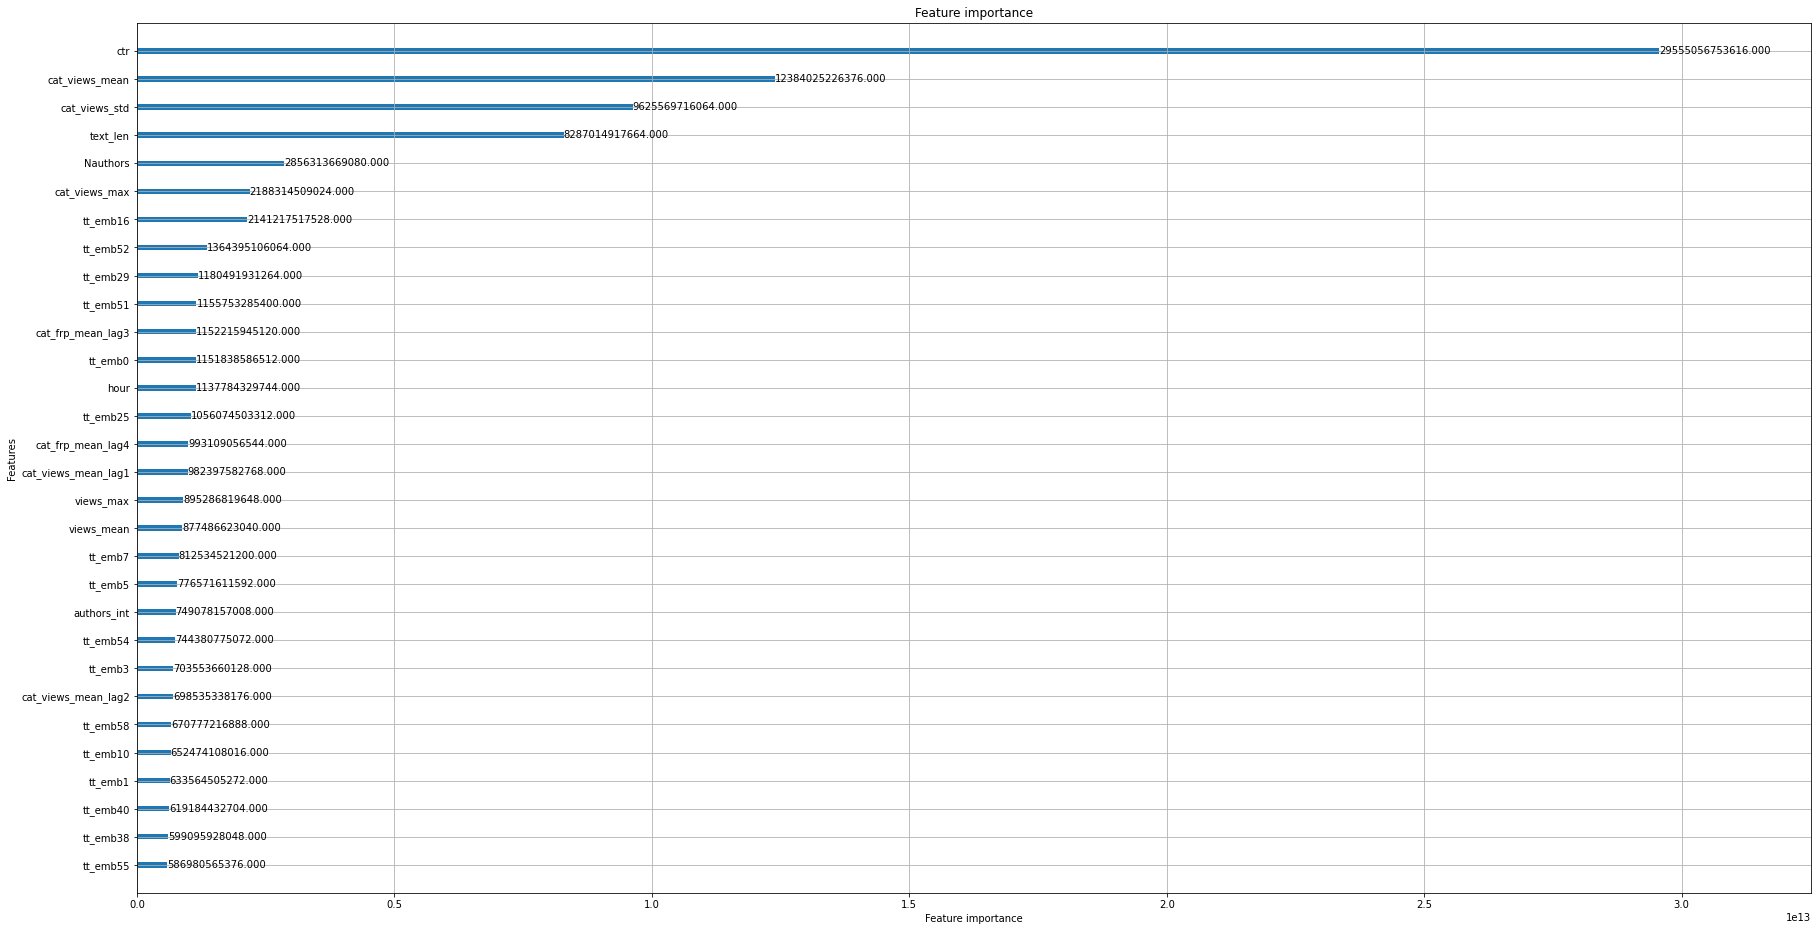

In [26]:
lgb.plot_importance(lgb_model_views_start, max_num_features = 30, figsize = (30, 16), importance_type = 'gain')
#lgb.plot_importance(lgb_model_views, max_num_features = 30, figsize = (30, 16), importance_type = 'split')
# importance_type (str, optional (default="auto")) – How the importance is calculated. If “auto”, if booster parameter is LGBMModel, booster.importance_type attribute is used; 
# “split” otherwise. If “split”, result contains numbers of times the feature is used in a model. If “gain”, result contains total gains of splits which use the feature.

In [27]:
%%time
lgb_model_views_end = get_model(train_views_end, params)

C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	cv_agg's train rmse: 727.442 + 182.176	cv_agg's train r2: 0.997404 + 0.00104188	cv_agg's valid rmse: 9129.59 + 660.541	cv_agg's valid r2: 0.395197 + 0.084018
77 3761.9464700862563 110.23969646181965
77 9034.796767591883 653.1865103504509
594 0.9982820753801376 0.0007119406104623806
594 0.39582136029449727 0.08405930983273119
77


C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Wall time: 23.3 s


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

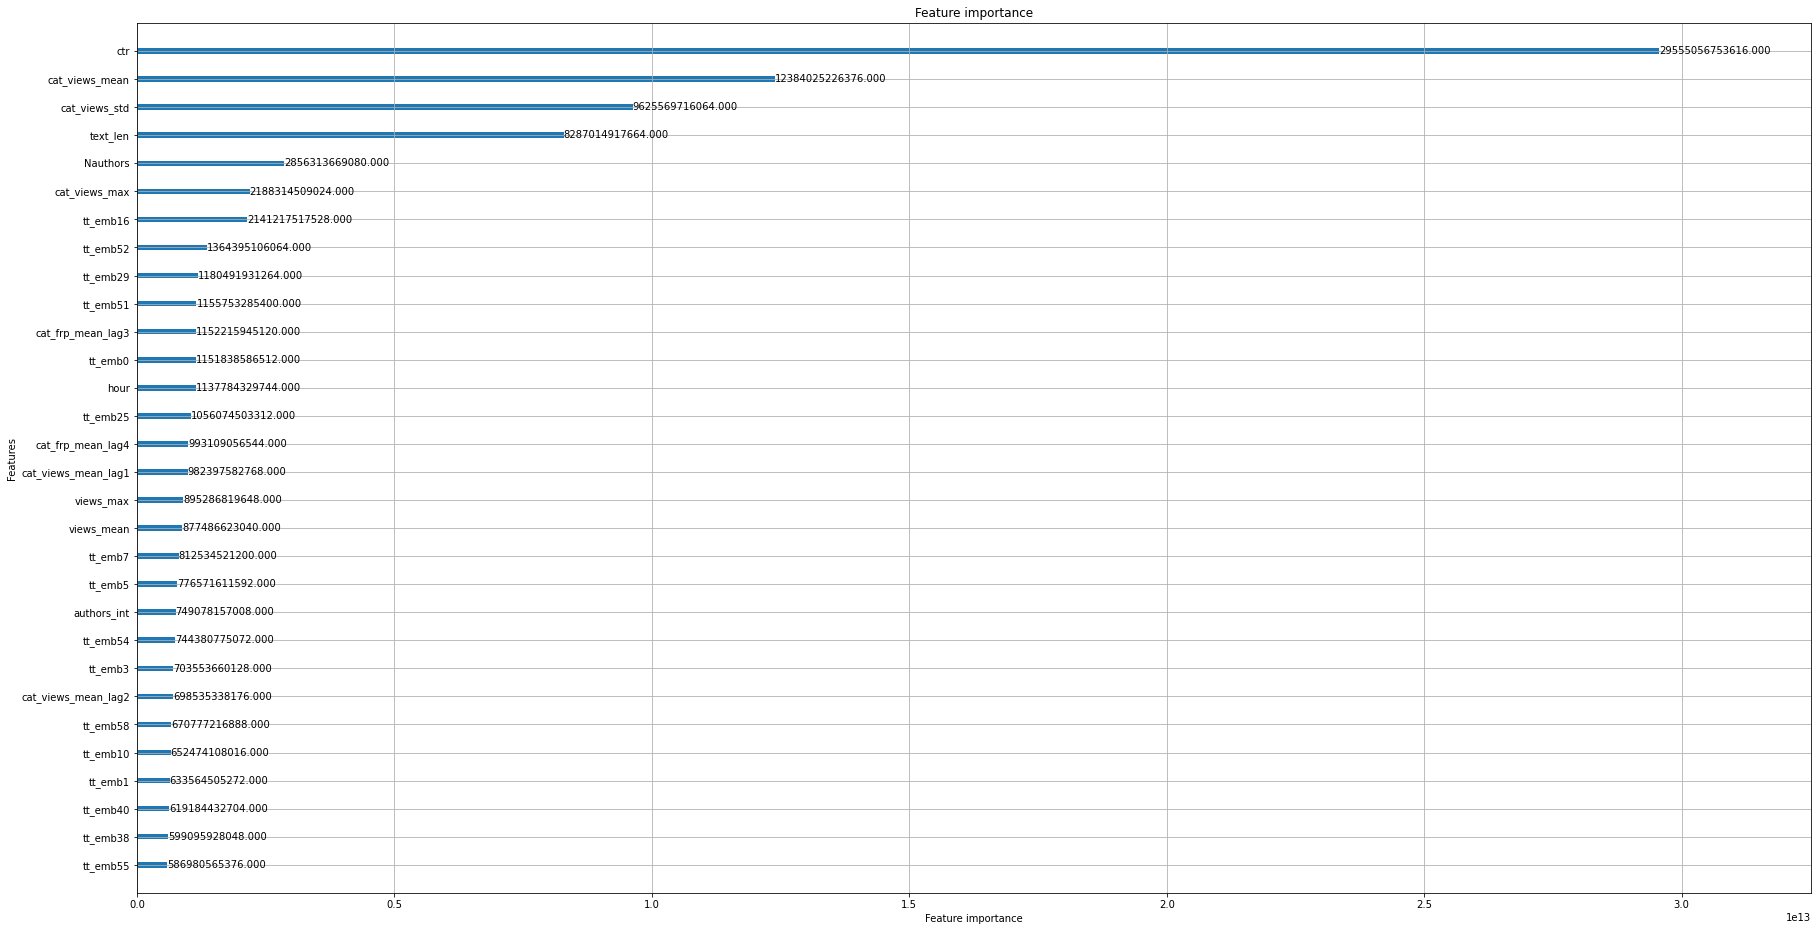

In [28]:
lgb.plot_importance(lgb_model_views_start, max_num_features = 30, figsize = (30, 16), importance_type = 'gain')

## depth

In [29]:
# defining parameters 
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    #'num_leaves': 10,
    #'learning_rate': 0.05,
    #'metric': {'l2','l1'},
    'metric': {'rmse'},
    'verbose': -1,
    
    #'reg_alpha': 5,   # != 0  Hard L1 regularization
    #'reg_lambda': 10,   # != 0  Hard L2 regularization
    
    #'lambda_l1': 5, 
    #'lambda_l2': 5,
    
    'random_seed': LGB_RANDOMSEED,
}

In [30]:
#if np.argmin(score_d['valid rmse-mean']) != np.argmax(score_d['valid r2-mean']):
#    raise ValueError('wtf?', np.argmin(score_d['valid rmse-mean']), np.argmax(score_d['valid r2-mean']))

In [31]:
%%time
lgb_model_depth_start = get_model(train_depth_start, params)

C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	cv_agg's train rmse: 0.00136107 + 0.000488069	cv_agg's train r2: 0.999243 + 0.000429074	cv_agg's valid rmse: 0.0361117 + 0.00345884	cv_agg's valid r2: 0.19628 + 0.201013
92 0.012774675718467876 0.00043797150418636567
92 0.03574606040187936 0.0030533996509353564
573 0.9995501582781822 0.0002656242554073824
573 0.19643686749941408 0.2002338299997168
92


C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Wall time: 24.3 s


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

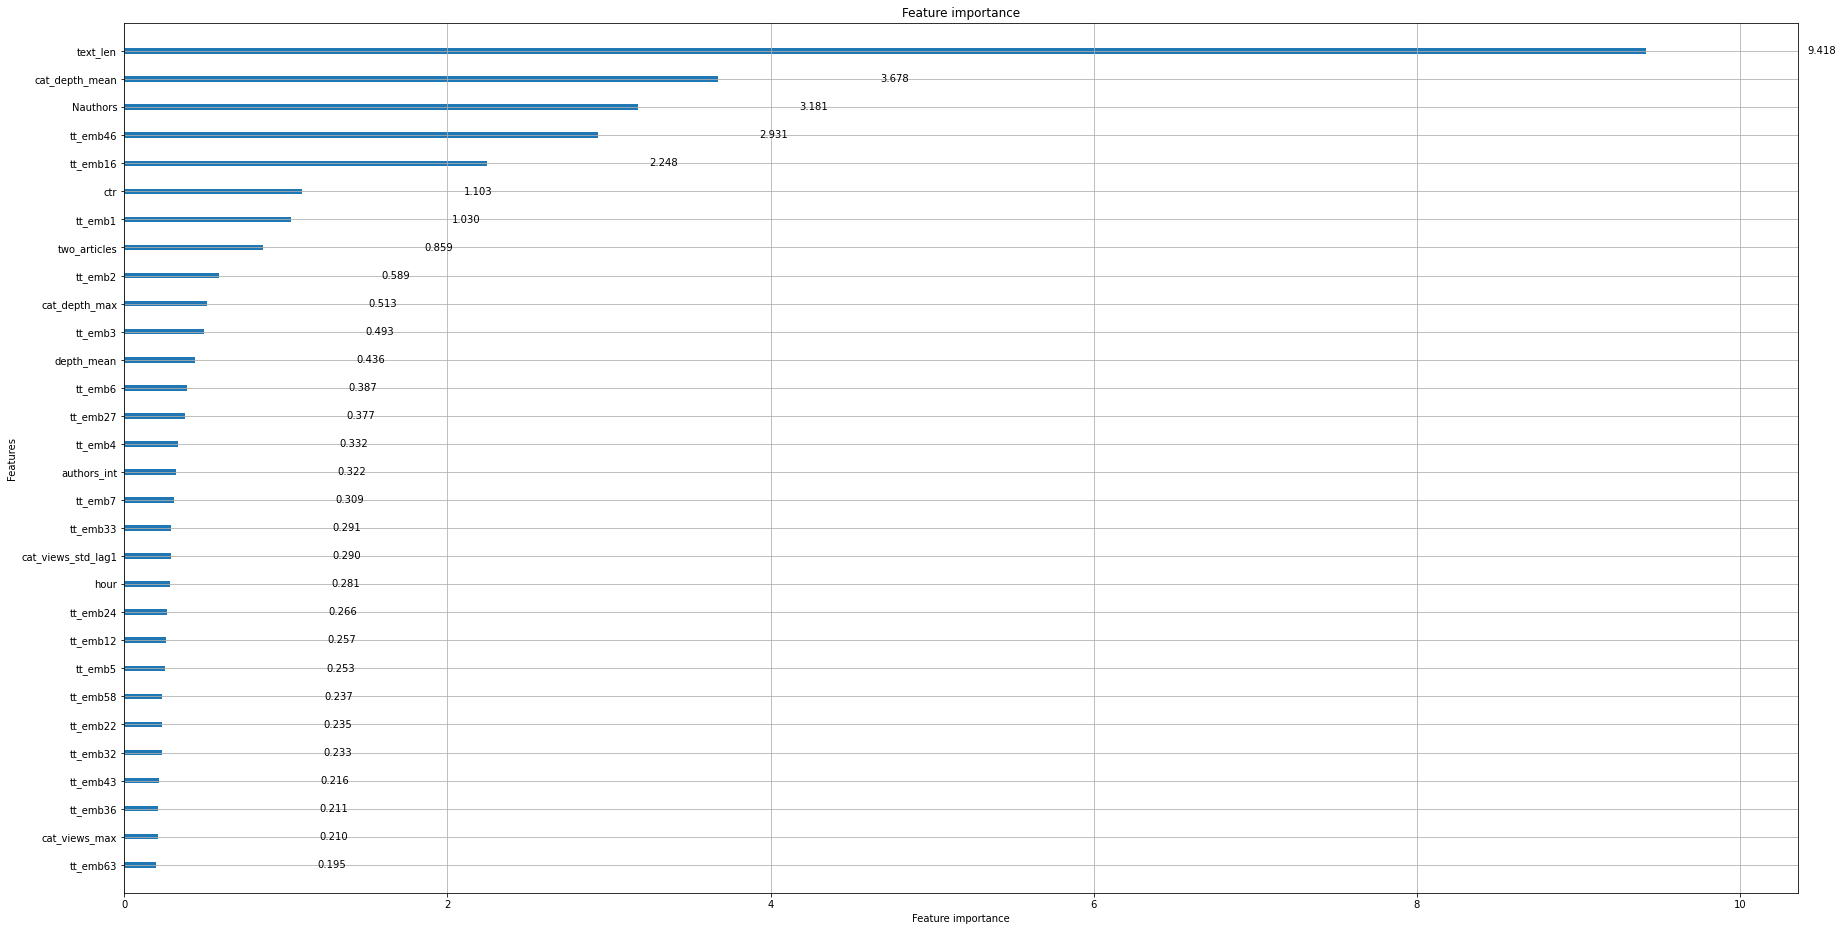

In [32]:
lgb.plot_importance(lgb_model_depth_start, max_num_features = 30, figsize = (30, 16), importance_type = 'gain')
#lgb.plot_importance(lgb_model_depth, max_num_features = 30, figsize = (30, 16), importance_type = 'split')

In [33]:
%%time
lgb_model_depth_end = get_model(train_depth_end, params)

C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	cv_agg's train rmse: 0.00215894 + 0.000398509	cv_agg's train r2: 0.98889 + 0.00343156	cv_agg's valid rmse: 0.0157503 + 0.00223161	cv_agg's valid r2: -0.121276 + 0.237365
48 0.010399829750017912 0.0008243396934630533
48 0.015475994859493908 0.002194558006310076
152 0.88781829869895 0.028713245000507693
152 -0.10924052609287349 0.2370082697987645
48


C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Wall time: 22 s


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

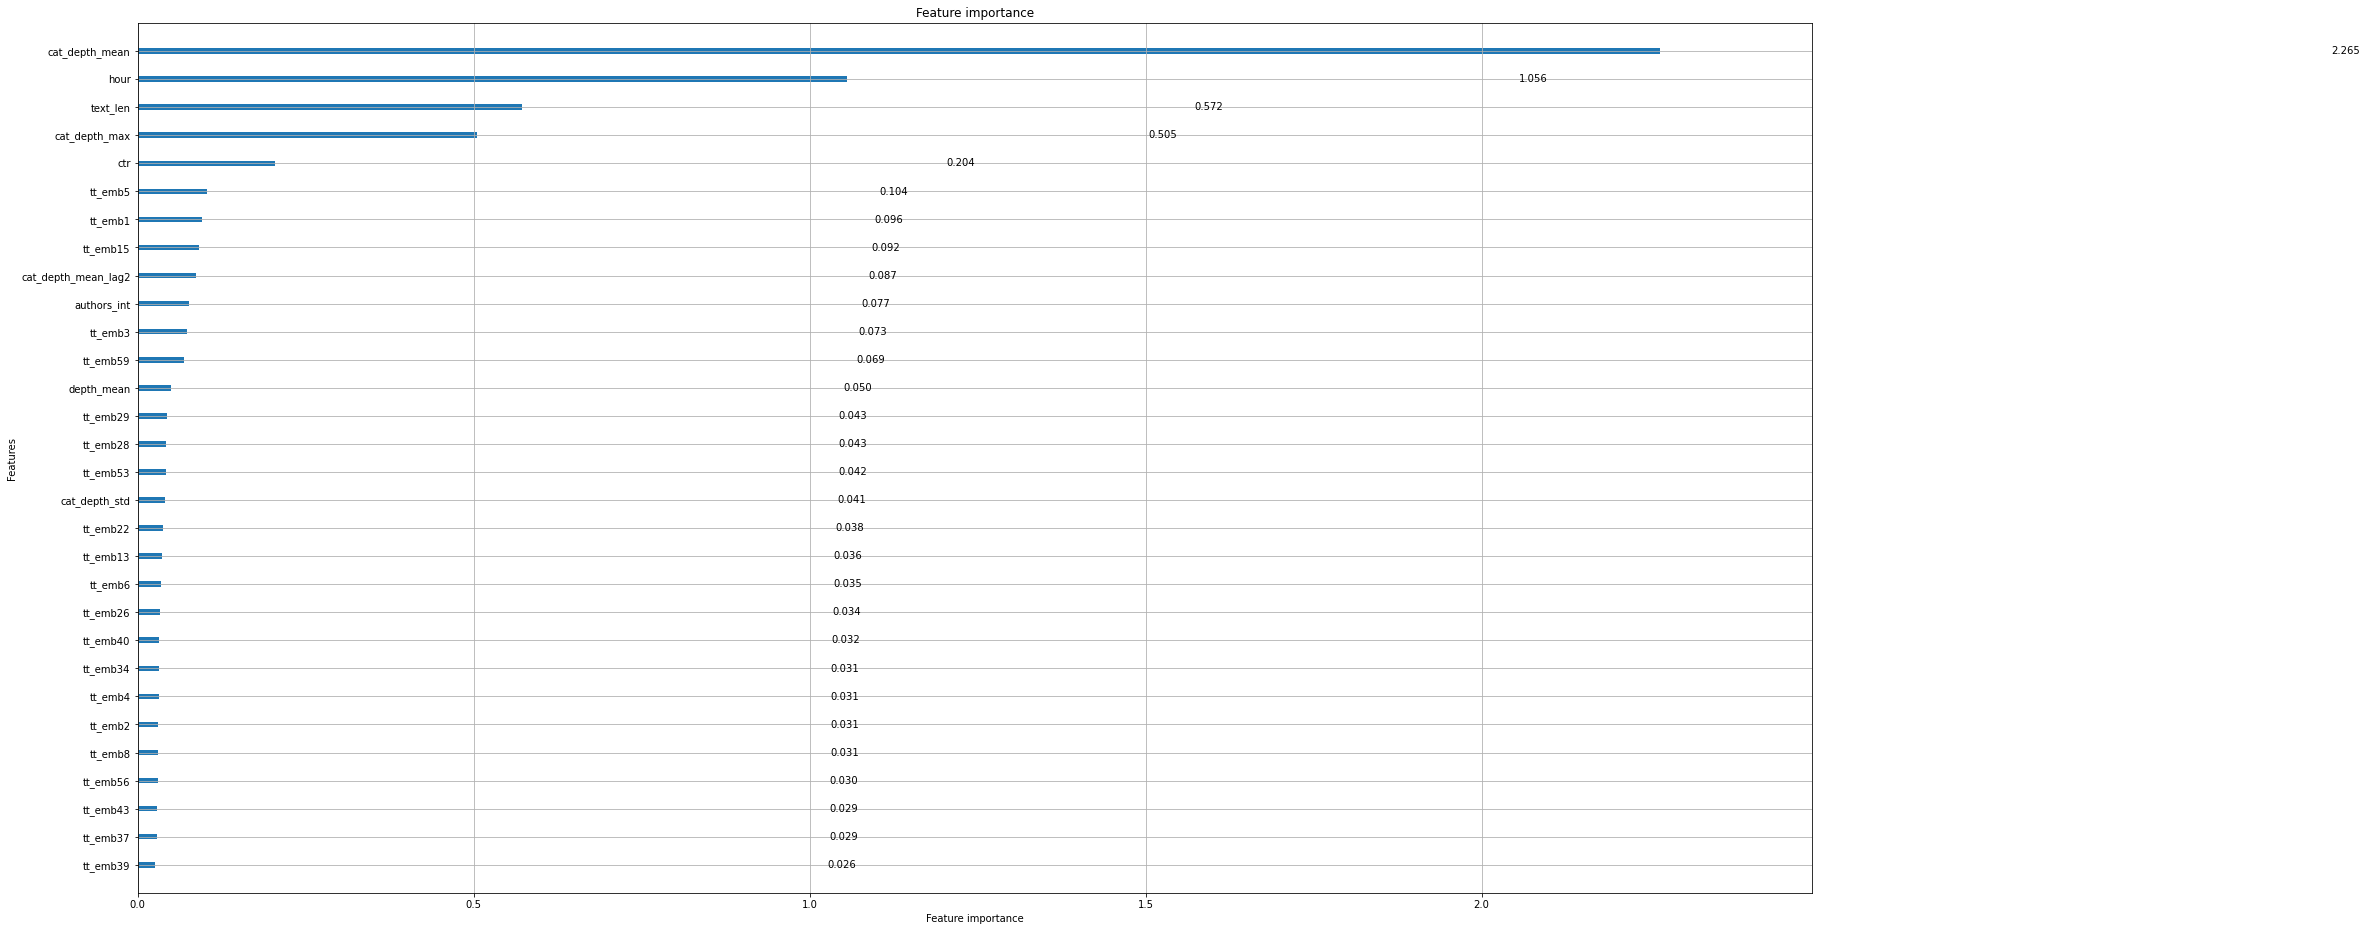

In [34]:
lgb.plot_importance(lgb_model_depth_end, max_num_features = 30, figsize = (30, 16), importance_type = 'gain')
#lgb.plot_importance(lgb_model_depth, max_num_features = 30, figsize = (30, 16), importance_type = 'split')

## full_reads_percent

In [35]:
#if np.argmin(score_f['valid rmse-mean']) != np.argmax(score_f['valid r2-mean']):
#    raise ValueError('wtf?', np.argmin(score_f['valid rmse-mean']), np.argmax(score_f['valid r2-mean']))

In [36]:
# defining parameters 
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    #'num_leaves': 10,
    #'learning_rate': 0.05,
    #'metric': {'l2','l1'},
    'metric': {'rmse'},
    'verbose': -1,
    
    #'reg_alpha': 5,   # != 0  Hard L1 regularization
    #'reg_lambda': 10,   # != 0  Hard L2 regularization
    
    #'lambda_l1': 5, 
    #'lambda_l2': 5,
    
    'random_seed': LGB_RANDOMSEED,
}

In [37]:
%%time
lgb_model_frp_start = get_model(train_frp_start, params)

C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	cv_agg's train rmse: 0.0667527 + 0.00590557	cv_agg's train r2: 0.999959 + 6.81789e-06	cv_agg's valid rmse: 7.10272 + 0.0747716	cv_agg's valid r2: 0.206727 + 0.0461925
54 3.5817026929454285 0.015001174048343903
54 7.035757899813923 0.08849771756751056
595 0.9999865067049409 4.103913185863769e-06
595 0.20692602483112052 0.046115697781979326
54


C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Wall time: 21.7 s


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

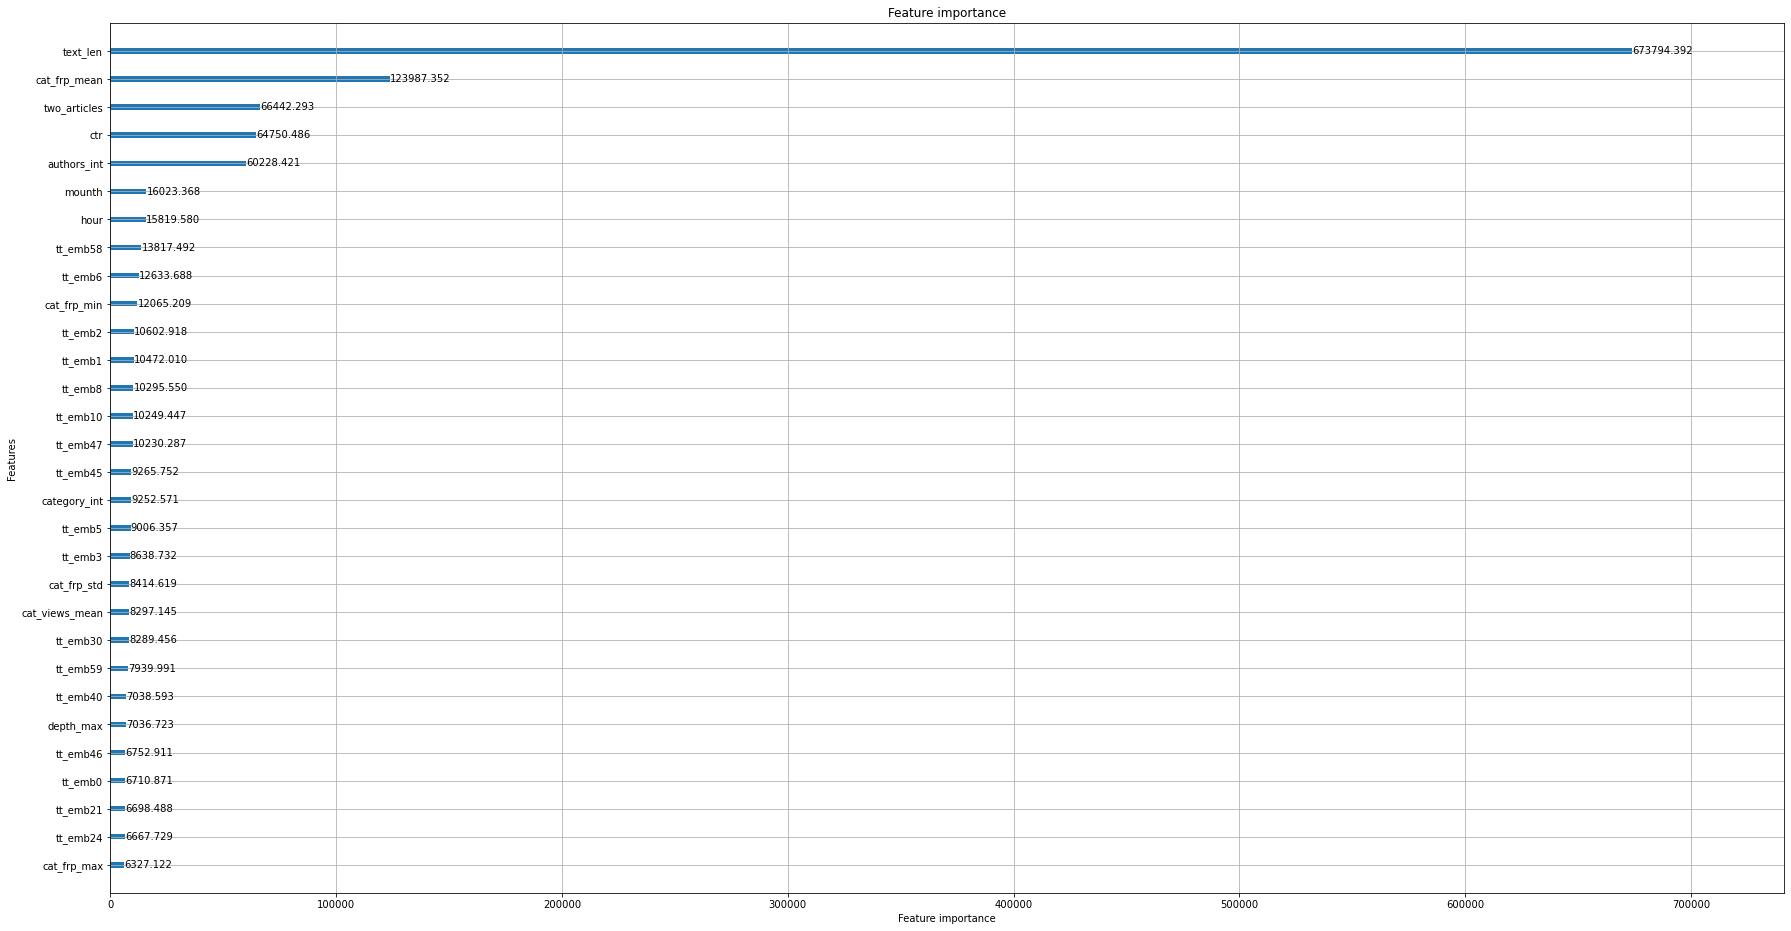

In [38]:
lgb.plot_importance(lgb_model_frp_start, max_num_features = 30, figsize = (30, 16), importance_type = 'gain')
#lgb.plot_importance(lgb_model_frp, max_num_features = 30, figsize = (30, 16), importance_type = 'split')

In [39]:
%%time
lgb_model_frp_end = get_model(train_frp_end, params)

C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	cv_agg's train rmse: 0.14803 + 0.01331	cv_agg's train r2: 0.999762 + 4.06286e-05	cv_agg's valid rmse: 6.49856 + 0.134019	cv_agg's valid r2: 0.220639 + 0.0339756
71 3.1057100118726253 0.014663128279285759
71 6.440356846362912 0.14059759791727314
579 0.9998791378577808 2.7910737751575036e-05
579 0.22069831297886422 0.033999064965479324
71


C:\Users\_v010ch_\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Wall time: 22 s


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

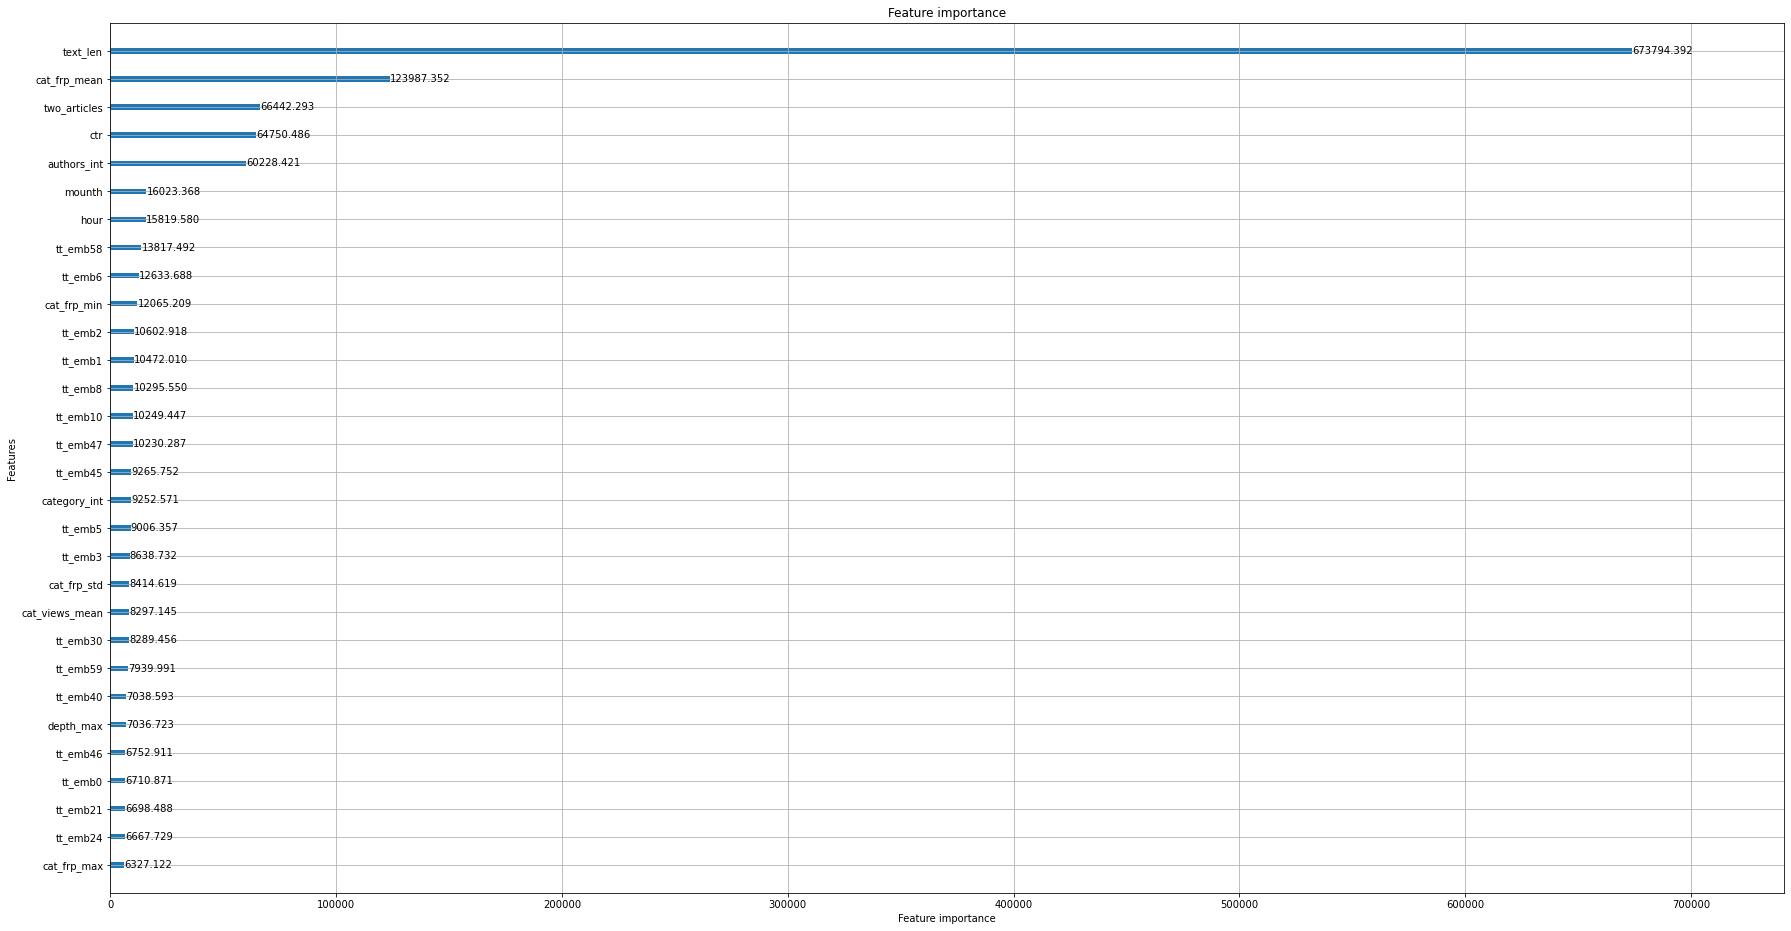

In [40]:
lgb.plot_importance(lgb_model_frp_start, max_num_features = 30, figsize = (30, 16), importance_type = 'gain')
#lgb.plot_importance(lgb_model_frp, max_num_features = 30, figsize = (30, 16), importance_type = 'split')

# Сохраняем предсказания для ансамблей / стекинга

## save models

In [41]:
lgb_model_views_start.save_model(os.path.join(DIR_MODELS, f'{NAME}_v_start.txt'), num_iteration = lgb_model_views_start.best_iteration)
lgb_model_views_end.save_model(  os.path.join(DIR_MODELS, f'{NAME}_v_end.txt'),   num_iteration = lgb_model_views_end.best_iteration)
lgb_model_depth_start.save_model(os.path.join(DIR_MODELS, f'{NAME}_d_start.txt'), num_iteration = lgb_model_depth_start.best_iteration)
lgb_model_depth_end.save_model(  os.path.join(DIR_MODELS, f'{NAME}_d_end.txt'),   num_iteration = lgb_model_depth_end.best_iteration)
lgb_model_frp_start.save_model(  os.path.join(DIR_MODELS, f'{NAME}_f_start.txt'), num_iteration = lgb_model_frp_start.best_iteration)
lgb_model_frp_end.save_model(    os.path.join(DIR_MODELS, f'{NAME}_f_end.txt'),   num_iteration = lgb_model_frp_end.best_iteration)

## Делаем предсказание трейна для ансамблей

In [59]:
pred_train = pd.DataFrame()
pred_train[['document_id', 'distrib_brdr']] = df_train[['document_id', 'distrib_brdr']]
pred_train = pred_train.reindex(['document_id', 'distrib_brdr', 'views', 'depth', 'full_reads_percent'], axis = 1)

In [60]:
pred_train.loc[pred_train.query('distrib_brdr == 1').index, 'views'] = lgb_model_views_start.predict(df_train[df_train.distrib_brdr == 1][cat_cols + num_cols])
pred_train.loc[pred_train.query('distrib_brdr == 0').index, 'views'] = lgb_model_views_end.predict(df_train[df_train.distrib_brdr == 0][cat_cols + num_cols])
print(sum(pred_train.views.isna()), ' Nan in views')

0  Nan in views


In [63]:
pred_train.loc[pred_train.query('distrib_brdr == 1').index, 'depth'] = lgb_model_depth_start.predict(df_train[df_train.distrib_brdr == 1][cat_cols + num_cols])
pred_train.loc[pred_train.query('distrib_brdr == 0').index, 'depth'] = lgb_model_depth_end.predict(df_train[df_train.distrib_brdr == 0][cat_cols + num_cols])
print(sum(pred_train.depth.isna()), ' Nan in depth')

0  Nan in depth


In [64]:
pred_train.loc[pred_train.query('distrib_brdr == 1').index, 'full_reads_percent'] = lgb_model_frp_start.predict(df_train[df_train.distrib_brdr == 1][cat_cols + num_cols])
pred_train.loc[pred_train.query('distrib_brdr == 0').index, 'full_reads_percent'] = lgb_model_frp_end.predict(df_train[df_train.distrib_brdr == 0][cat_cols + num_cols])
print(sum(pred_train.full_reads_percent.isna()), ' Nan in full_reads_percent')

0  Nan in full_reads_percent


In [65]:
pred_train.drop(['distrib_brdr'], axis =1, inplace = True)
pred_train.to_csv(os.path.join(DIR_SUBM_PART, f'{NAME}_train_part.csv'), index = False)

# Делаем предсказание для теста

In [47]:
subm = pd.DataFrame()
subm[['document_id', 'distrib_brdr']] = df_test[['document_id', 'distrib_brdr']]
subm = subm.reindex(['document_id', 'distrib_brdr', 'views', 'depth', 'full_reads_percent'], axis = 1)

In [48]:
subm.loc[subm.query('distrib_brdr == 1').index, 'views'] = lgb_model_views_start.predict(df_test[df_test.distrib_brdr == 1][cat_cols + num_cols])
subm.loc[subm.query('distrib_brdr == 0').index, 'views'] = lgb_model_views_end.predict(df_test[df_test.distrib_brdr == 0][cat_cols + num_cols])
sum(subm.views.isna())

0

In [49]:
subm.loc[subm.query('distrib_brdr == 1').index, 'depth'] = lgb_model_depth_start.predict(df_test[df_test.distrib_brdr == 1][cat_cols + num_cols])
subm.loc[subm.query('distrib_brdr == 0').index, 'depth'] = lgb_model_depth_end.predict(df_test[df_test.distrib_brdr == 0][cat_cols + num_cols])
sum(subm.depth.isna())

0

In [50]:
subm.loc[subm.query('distrib_brdr == 1').index, 'full_reads_percent'] = lgb_model_frp_start.predict(df_test[df_test.distrib_brdr == 1][cat_cols + num_cols])
subm.loc[subm.query('distrib_brdr == 0').index, 'full_reads_percent'] = lgb_model_frp_end.predict(df_test[df_test.distrib_brdr == 0][cat_cols + num_cols])
sum(subm.full_reads_percent.isna())

0

In [51]:
subm.drop(['distrib_brdr'], axis = 1, inplace = True)

In [52]:
doc_id_ukr = df_test[df_test.spec == 1].document_id.values
subm.query('document_id in @doc_id_ukr')[['views', 'depth', 'full_reads_percent']]

,views,depth,full_reads_percent
945,159256.893205,1.136944,23.252879
1440,154976.053257,1.152313,24.551462
2645,159220.924800,1.169158,23.071891


In [53]:
# присваиваем статичные данные
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'views'] = VIEWS_UKR
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'depth'] = DEPTH_UKR
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'full_reads_percent'] = FPR_UKR

subm.query('document_id in @doc_id_ukr')[['views', 'depth', 'full_reads_percent']]

,views,depth,full_reads_percent
945,2554204.0,1.799,4.978
1440,2554204.0,1.799,4.978
2645,2554204.0,1.799,4.978


In [54]:
subm.head()

,document_id,views,depth,full_reads_percent
0,61f9569a9a794794245a82abJ0AvX96vTAaQCiWVbzoMdw,11067.588253,1.207550,43.628577
1,628c22b89a79470e553f594bQS5CqzXYRnmDdR2LaSreEw,7186.802178,1.059333,30.539822
2,627cb3249a7947ebdd752865XVsoyrUOT8OJJg2_finJhw,11441.006980,1.057789,28.896757
3,628618629a7947d4927eb812upfii3whSSuMXCqcqF8VbQ,5137.135680,1.060298,38.883983
4,620e76109a7947235623695b5hzCiIHdSYKQIr8WAM18bw,81444.431489,1.146364,29.462053


In [55]:
subm.to_csv(os.path.join(DIR_SUBM, f'{NAME}.csv'), index = False)